# Metric correlation 


In [ ]:
import os
import ast
import random
from typing import Callable, Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from transformers import AutoTokenizer, AutoModel

In [23]:
# IsoScore
try:
    from IsoScore.IsoScore import IsoScore  # function: IsoScore(points)
except Exception as e:
    raise ImportError(
        "Missing dependency: IsoScore. Install with: pip install IsoScore\n"
        f"Original error: {e}"
    )

# DADApy
try:
    from dadapy.data import Data
except Exception as e:
    raise ImportError(
        "Missing dependency: dadapy. Install with: pip install dadapy\n"
        f"Original error: {e}"
    )

# scikit-dimension
try:
    from skdim.id import MOM, TLE, CorrInt, FisherS, lPCA, MLE, MADA, ESS
except Exception as e:
    raise ImportError(
        "Missing dependency: scikit-dimension (skdim). Install with: pip install scikit-dimension\n"
        f"Original error: {e}"
    )


In [24]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
RAND_SEED = 42
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 120

device: cuda


In [44]:
CSV_PATH = "data/en_ewt-ud-train_sentences.csv"   # expects columns: sentence_id, tokens, pos
MODEL_NAME = "bert-base-uncased" #or gpt2
LAYER_IDX = 12                 # 0 = embeddings, last layer depends on model depth
WORD_REP_MODE = "last"         # {"first","last","mean"}
EXCLUDE_POS = {"X", "SYM", "INTJ", "PART"}  # optional

POOL_SIZE = 100             # 20_000 in paper 
SUBSAMPLE_M = 50            # 2000 in paper 
N_POINTS = 200                 # 200 in paper 
HEAVY_MAX_N = 2_000            # cap for kNN estimators (keep = SUBSAMPLE_M for paper settings)
DADAPY_GRID_RANGE_MAX = 64     # GRIDE range_max

BATCH_SIZE_SENT = 16
MAX_LENGTH = 256




In [45]:
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 120

In [46]:
def _as_list(x):
    if isinstance(x, str) and x.startswith("["):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

def load_sentences_and_words(csv_path: str, exclude_pos: Optional[set[str]] = None):
    df = pd.read_csv(csv_path, usecols=["sentence_id", "tokens", "pos"])
    df["tokens"] = df["tokens"].apply(_as_list)
    df["pos"] = df["pos"].apply(_as_list)
    df = df.set_index("sentence_id", drop=False)

    rows = []
    for sid, row in df.iterrows():
        toks = row["tokens"]
        poss = row["pos"]
        for wid, (_, pos) in enumerate(zip(toks, poss)):
            if exclude_pos and pos in exclude_pos:
                continue
            rows.append((sid, wid))

    words_df = pd.DataFrame(rows, columns=["sentence_id", "word_id"])
    return df, words_df



In [47]:
def sample_pool_words(words_df: pd.DataFrame, n: int, seed: int = 0) -> pd.DataFrame:
    if n >= len(words_df):
        out = words_df.copy()
    else:
        out = words_df.sample(n=n, random_state=seed).copy()

    out = out.reset_index(drop=True)
    out["global_idx"] = np.arange(len(out), dtype=np.int64)
    return out

df_sent, all_words = load_sentences_and_words(CSV_PATH, exclude_pos=EXCLUDE_POS)
pool_words = sample_pool_words(all_words, POOL_SIZE, seed=RAND_SEED)

print("sentences:", len(df_sent))
print("candidate words:", len(all_words))
print("pool words:", len(pool_words))


sentences: 10067
candidate words: 189167
pool words: 100


In [48]:
def build_tokenizer_and_model(model_name: str):
    try:
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=True)
    except TypeError:
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    model = AutoModel.from_pretrained(model_name, output_hidden_states=True).eval().to(device)

    if device.type == "cuda":
        model.half()

    return tok, model

In [49]:
@torch.inference_mode()
def embed_words_one_layer(
    df_sent: pd.DataFrame,
    words_df: pd.DataFrame,
    tokenizer,
    model,
    layer_idx: int,
    mode: str = "last",
    batch_size: int = 16,
    max_length: int = 256,
) -> np.ndarray:
    by_sent = words_df.groupby("sentence_id")
    sent_ids = list(by_sent.groups.keys())

    hidden_size = int(model.config.hidden_size)
    reps = np.zeros((len(words_df), hidden_size), dtype=np.float32)
    filled = np.zeros((len(words_df),), dtype=bool)

    for b0 in tqdm(range(0, len(sent_ids), batch_size), desc="embedding"):
        batch_sids = sent_ids[b0 : b0 + batch_size]
        batch_tokens = df_sent.loc[batch_sids, "tokens"].tolist()

        enc = tokenizer(
            batch_tokens, is_split_into_words=True, return_tensors="pt",
            padding=True, truncation=True, max_length=max_length
        )
        
        if not getattr(tokenizer, "is_fast", False):
            raise ValueError(
                "This notebook requires a *fast* tokenizer (use_fast=True) to call enc.word_ids()."
            )
        word_ids_list = [enc.word_ids(batch_index=bi) for bi in range(len(batch_sids))]
        
        if hasattr(enc, "to"):
            enc = enc.to(device)
        else:
            enc = {k: v.to(device) for k, v in enc.items()}

        out = model(**enc)
        hs = out.hidden_states[layer_idx].float()  # (B,T,D)

        for bi, sid in enumerate(batch_sids):
            word_ids = enc.word_ids(batch_index=bi)

            pos_map: Dict[int, List[int]] = {}
            for ti, wid in enumerate(word_ids):
                if wid is None:
                    continue
                pos_map.setdefault(int(wid), []).append(int(ti))

            req = by_sent.get_group(sid)
            for _, r in req.iterrows():
                wid = int(r["word_id"])
                gidx = int(r["global_idx"])
                toks = pos_map.get(wid)
                if not toks:
                    continue

                if mode == "first":
                    vec = hs[bi, toks[0], :]
                elif mode == "mean":
                    vec = hs[bi, toks, :].mean(dim=0)
                else:  # "last"
                    vec = hs[bi, toks[-1], :]

                reps[gidx] = vec.detach().cpu().numpy().astype(np.float32, copy=False)
                filled[gidx] = True

        del enc, out, hs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    if not filled.all():
        reps = reps[filled]
        print(f"⚠ Dropped {(~filled).sum()} words (alignment / truncation). pool now:", reps.shape[0])

    return reps

In [50]:
tokenizer, model = build_tokenizer_and_model(MODEL_NAME)
X_pool = embed_words_one_layer(
    df_sent=df_sent,
    words_df=pool_words,
    tokenizer=tokenizer,
    model=model,
    layer_idx=LAYER_IDX,
    mode=WORD_REP_MODE,
    batch_size=BATCH_SIZE_SENT,
    max_length=MAX_LENGTH,
)
print("X_pool:", X_pool.shape)


embedding:   0%|          | 0/7 [00:00<?, ?it/s]

X_pool: (100, 768)


In [51]:
EPS = 1e-9

def _center(X: np.ndarray) -> np.ndarray:
    return X - X.mean(0, keepdims=True)

def _eigvals_from_X(X: np.ndarray) -> np.ndarray:
    """Return eigenvalues of X^T X (descending), computed via SVD of centered X.
    Uses GPU if available (torch), falls back to numpy.
    """
    Xc = X.astype(np.float32, copy=False)
    if device.type == "cuda":
        Xt = torch.as_tensor(Xc, device=device)
        Xt = Xt - Xt.mean(dim=0, keepdim=True)
        S = torch.linalg.svdvals(Xt)            # singular values
        lam = (S * S).detach().cpu().numpy()    # eigenvalues of Xt^T Xt (up to scalar)
        lam = lam.astype(np.float64, copy=False)
        lam.sort()
        return lam[::-1]
    else:
        Xc = _center(Xc)
        _, S, _ = np.linalg.svd(Xc, full_matrices=False)
        lam = (S ** 2).astype(np.float64)
        lam.sort()
        return lam[::-1]

def _jitter_unique(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Add tiny noise if there are duplicate rows (helps NN-based estimators)."""
    try:
        if np.unique(X, axis=0).shape[0] < X.shape[0]:
            X = X + np.random.normal(scale=eps, size=X.shape).astype(X.dtype)
    except Exception:
        pass
    return X

def spectral_flatness_from_eigs(lam: np.ndarray) -> float:
    gm = np.exp(np.mean(np.log(lam + EPS)))
    am = float(lam.mean() + EPS)
    return float(gm / am)

def effective_rank_from_eigs(lam: np.ndarray) -> float:
    p = lam / (lam.sum() + EPS)
    H = -(p * np.log(p + EPS)).sum()
    return float(np.exp(H))

def participation_ratio_from_eigs(lam: np.ndarray) -> float:
    s1 = lam.sum()
    s2 = (lam ** 2).sum()
    return float((s1 ** 2) / (s2 + EPS))

def stable_rank_from_eigs(lam: np.ndarray) -> float:
    return float(lam.sum() / (lam.max() + EPS))

# ---------- other metrics ----------
def iso_score(X: np.ndarray) -> float:
    Xt = torch.from_numpy(X.astype(np.float32, copy=False))
    return float(IsoScore(Xt))

def vmf_kappa(X: np.ndarray) -> float:
    if X.shape[0] < 2:
        return float("nan")
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    R = np.linalg.norm(Xn.mean(axis=0))
    d = Xn.shape[1]
    if R < 1e-9:
        return 0.0
    return float(max(R * (d - R**2) / (1.0 - R**2 + 1e-9), 0.0))

def lpca_fo(X: np.ndarray) -> float:
    est = lPCA(ver="FO")
    est.fit(X)
    return float(est.dimension_)

def lpca_099(X: np.ndarray) -> float:
    est = lPCA(ver="ratio", alphaRatio=0.99)
    est.fit(X)
    return float(est.dimension_)


In [52]:

def twonn_id(X: np.ndarray) -> float:
    d = Data(_jitter_unique(X))
    id_est, _, _ = d.compute_id_2NN()
    return float(id_est)

def gride_id(X: np.ndarray) -> float:
    d = Data(_jitter_unique(X))
    d.compute_distances(maxk=DADAPY_GRID_RANGE_MAX)
    ids, _, _ = d.return_id_scaling_gride(range_max=DADAPY_GRID_RANGE_MAX)
    return float(ids[-1])

def _skdim_fit_dim(X: np.ndarray, est_ctor: Callable[[], object]) -> float:
    est = est_ctor()
    est.fit(_jitter_unique(X))
    return float(getattr(est, "dimension_", np.nan))

def mom_id(X: np.ndarray) -> float:      return _skdim_fit_dim(X, MOM)
def tle_id(X: np.ndarray) -> float:      return _skdim_fit_dim(X, TLE)
def corrint_id(X: np.ndarray) -> float:  return _skdim_fit_dim(X, CorrInt)
def fishers_id(X: np.ndarray) -> float:  return _skdim_fit_dim(X, FisherS)
def mle_id(X: np.ndarray) -> float:      return _skdim_fit_dim(X, MLE)
def ess_id(X: np.ndarray) -> float:      return _skdim_fit_dim(X, ESS)
def mada_id(X: np.ndarray) -> float:     return _skdim_fit_dim(X, MADA)


In [53]:
HEAVY: Dict[str, Callable[[np.ndarray], float]] = {
    "twonn": twonn_id,
    "gride": gride_id,
    "mle": mle_id,
    "mom": mom_id,
    "tle": tle_id,
    "corrint": corrint_id,
    "fishers": fishers_id,
    "ess": ess_id,
    "mada": mada_id,
}

DISPLAY = {
    "iso": "IsoScore",
    "sf": "Spectral Flatness",
    "vmf_kappa": "vMF κ",

    "erank": "Effective Rank",
    "pr": "Participation Ratio",
    "stable_rank": "Stable Rank",
    "lpca": "PCA–FO",
    "lpca99": "PCA–α (0.99)",

    "twonn": "TwoNN",
    "gride": "GRIDE",
    "mle": "MLE",
    "mom": "MOM",
    "tle": "TLE",
    "corrint": "CorrInt",
    "fishers": "FisherS",
    "ess": "ESS",
    "mada": "MADA",
}

METRIC_ORDER = [
    "iso", "sf", "vmf_kappa",
    "erank", "pr", "stable_rank", "lpca", "lpca99",
    "twonn", "gride", "mle", "mom", "tle", "corrint", "fishers", "ess", "mada",
]


In [54]:
def subsample_points(X_pool: np.ndarray, m: int, n_points: int, seed: int = 0):
    rng = np.random.default_rng(seed)
    n = X_pool.shape[0]
    if m > n:
        raise ValueError(f"SUBSAMPLE_M={m} > pool size {n}")
    return [rng.choice(n, size=m, replace=False) for _ in range(n_points)]

def compute_points_df(X_pool: np.ndarray, idxs: List[np.ndarray], heavy_cap: Optional[int] = None):
    rows = []
    for pid, idx in enumerate(tqdm(idxs, desc="metrics")):
        X = X_pool[idx].astype(np.float32, copy=False)
        rec = {"point_id": pid, "n": int(X.shape[0])}

        lam = _eigvals_from_X(X)
        rec["sf"] = spectral_flatness_from_eigs(lam)
        rec["erank"] = effective_rank_from_eigs(lam)
        rec["pr"] = participation_ratio_from_eigs(lam)
        rec["stable_rank"] = stable_rank_from_eigs(lam)

        # other fast metrics
        rec["iso"] = iso_score(X)
        rec["vmf_kappa"] = vmf_kappa(X)
        rec["lpca"] = lpca_fo(X)
        rec["lpca99"] = lpca_099(X)

        # heavy metrics on an optional cap
        Xh = X
        if heavy_cap is not None and X.shape[0] > heavy_cap:
            rng = np.random.default_rng(RAND_SEED + pid)
            sub = rng.choice(X.shape[0], size=heavy_cap, replace=False)
            Xh = X[sub].astype(np.float32, copy=False)

        for name, fn in HEAVY.items():
            try:
                rec[name] = float(fn(Xh))
            except Exception:
                rec[name] = np.nan

        rows.append(rec)

    df = pd.DataFrame(rows).set_index("point_id")
    df = df[[m for m in (["n"] + METRIC_ORDER) if m in df.columns]]
    return df


In [55]:
idxs = subsample_points(X_pool, m=SUBSAMPLE_M, n_points=N_POINTS, seed=RAND_SEED)
points_df = compute_points_df(X_pool, idxs, heavy_cap=HEAVY_MAX_N)
points_df.head()


metrics:   0%|          | 0/200 [00:00<?, ?it/s]

,n,iso,sf,vmf_kappa,erank,pr,stable_rank,lpca,lpca99,twonn,gride,mle,mom,tle,corrint,fishers,ess,mada
point_id,,,,,,,,,,,,,,,,,,
0,50,0.037764,0.483359,514.857100,38.515686,29.964794,11.182683,47.0,47.0,21.334565,NaN,18.467283,6.199917,18.025761,13.123626,7.891990,81.569995,21.582843
1,50,0.038398,0.481819,496.242431,38.814525,30.451579,10.868937,47.0,47.0,19.144336,NaN,17.807546,6.396526,17.370997,13.026491,7.891990,83.485069,21.042447
2,50,0.038707,0.483666,507.194106,38.794603,30.688532,11.412711,47.0,47.0,21.839931,NaN,16.741277,6.394615,15.911384,12.478601,8.592311,84.529877,18.082653
3,50,0.032989,0.452344,487.091008,36.127041,26.302538,9.314323,44.0,46.0,23.775154,NaN,14.608294,6.311331,15.616596,10.109709,6.656547,56.936890,18.474021
4,50,0.041962,0.503921,503.256674,40.378089,33.184654,11.870012,48.0,47.0,24.877497,NaN,20.054363,6.311069,18.617293,12.326383,12.120810,108.964512,19.602918


In [56]:
def _spearman_pair(x: pd.Series, y: pd.Series) -> Tuple[float, float]:
    mask = x.notna() & y.notna()
    if int(mask.sum()) < 3:
        return np.nan, np.nan
    res = spearmanr(x[mask].to_numpy(), y[mask].to_numpy())
    rho = getattr(res, "correlation", res[0])
    p = getattr(res, "pvalue", res[1])
    return float(rho), float(p)

def spearman_corr_and_pvals(df: pd.DataFrame, cols: List[str]):
    corr = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols, dtype=float)
    pval = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols, dtype=float)

    for i, a in enumerate(cols):
        for j in range(i + 1, len(cols)):
            b = cols[j]
            r, p = _spearman_pair(df[a], df[b])
            corr.loc[a, b] = corr.loc[b, a] = r
            pval.loc[a, b] = pval.loc[b, a] = p
    return corr, pval

metric_cols = [m for m in METRIC_ORDER if m in points_df.columns and points_df[m].notna().any()]
corr, pval = spearman_corr_and_pvals(points_df, metric_cols)

def p_to_stars(p: float) -> str:
    if not np.isfinite(p):
        return ""
    if p < 1e-3:
        return "***"
    if p < 1e-2:
        return "**"
    if p < 5e-2:
        return "*"
    return ""

corr_star = pd.DataFrame("", index=metric_cols, columns=metric_cols, dtype=object)
for i in metric_cols:
    for j in metric_cols:
        if i == j:
            corr_star.loc[i, j] = "1.00"
        else:
            r = corr.loc[i, j]
            corr_star.loc[i, j] = "" if not np.isfinite(r) else f"{r:.2f}{p_to_stars(pval.loc[i, j])}"

In [57]:
corr_plot = corr.rename(index=DISPLAY, columns=DISPLAY)
corr_star_plot = corr_star.rename(index=DISPLAY, columns=DISPLAY)

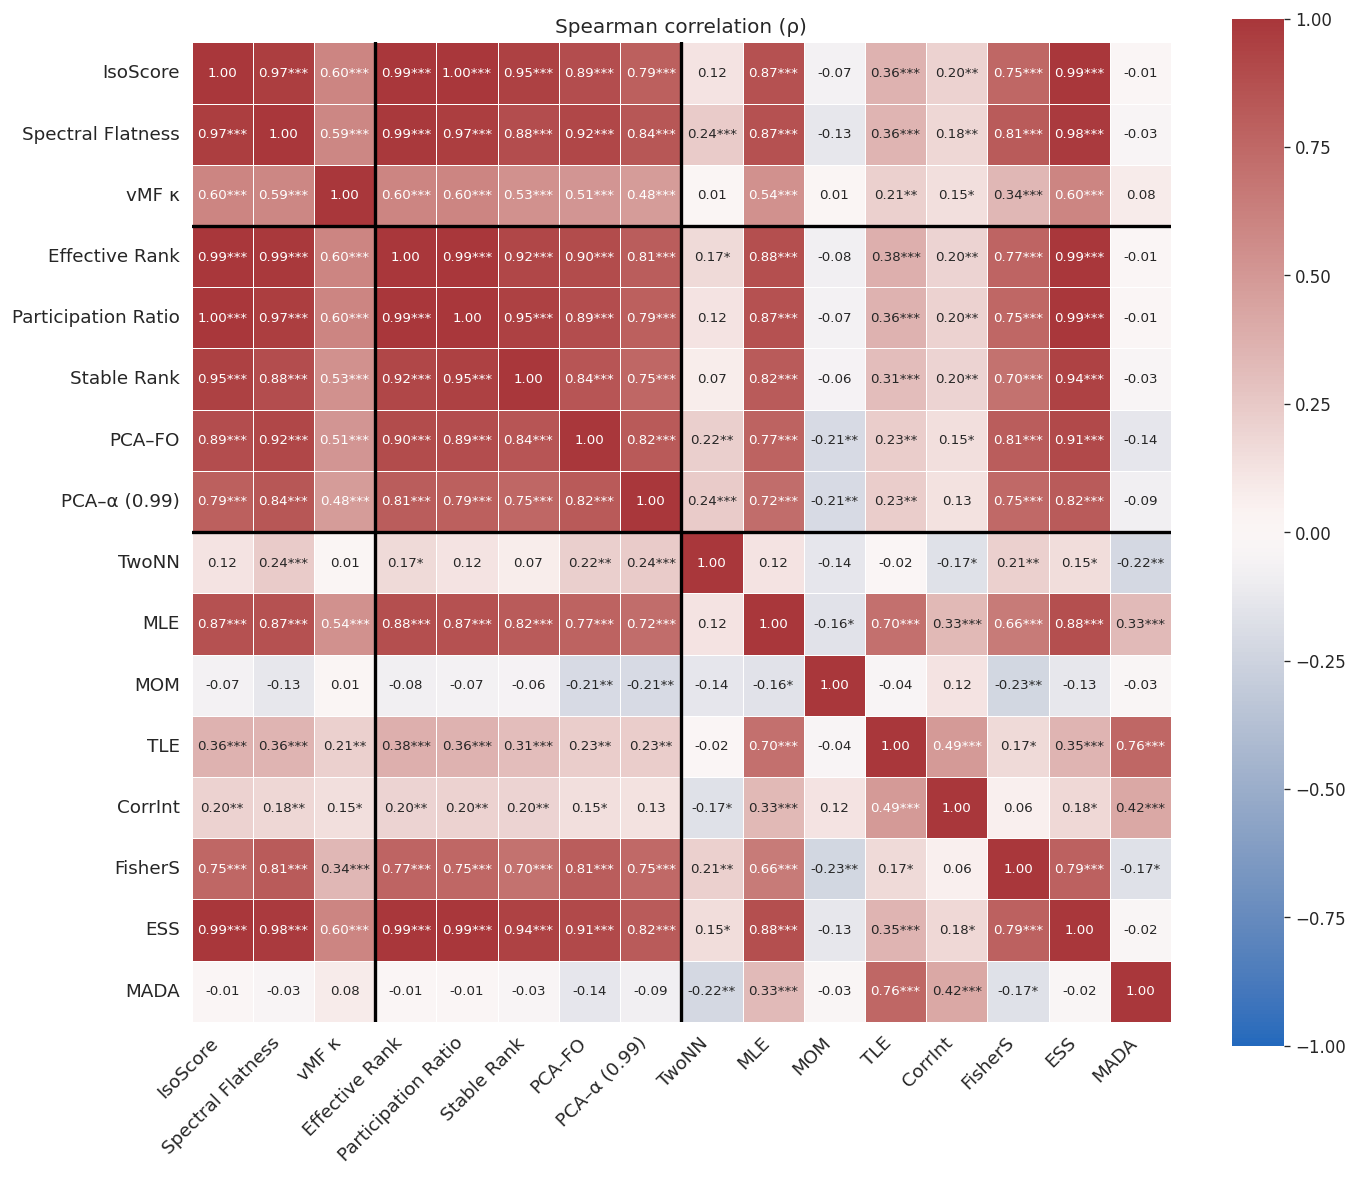

In [58]:
plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    corr_plot,
    vmin=-1, vmax=1, center=0,
    cmap="vlag",
    square=True,
    annot=corr_star_plot,
    fmt="",
    annot_kws={"fontsize": 8},
    linewidths=0.5,
)

ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

cuts = [3, 3 + 5]  # 3 iso metrics, 5 linear metrics
for cut in cuts:
    ax.axhline(cut, color="black", lw=2.0)
    ax.axvline(cut, color="black", lw=2.0)

plt.title("Spearman correlation (ρ)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(FIG_PATH, dpi=220)
    print("saved:", FIG_PATH)

plt.show()
